In [1]:
import shutil
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

dataset_path = Path("D:/dataset/faces")          
DATASET_DIR = Path("D:/dataset/cropped_faces")     
BASE_SPLIT_DIR = Path("D:/dataset/split_data")
MODELS_DIR = Path("D:/dataset/models")
IMG_SIZE = (224, 224)
BATCH_SIZE = 8


C:\Users\milha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
def extract_faces():
    if not dataset_path.exists():
        print(f"Skipping extraction: {dataset_path} not found.")
        return

    DATASET_DIR.mkdir(parents=True, exist_ok=True)
    
    # Load Haar Cascade classifier
    face_cascade = cv2.CascadeClassifier(
        cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    )

    total_saved = 0
    person_dirs = sorted([p for p in dataset_path.iterdir() if p.is_dir()])
    
    print("Starting face extraction...")
    for person_dir in person_dirs:
        out_person = DATASET_DIR / person_dir.name
        out_person.mkdir(parents=True, exist_ok=True)

        for img_path in person_dir.rglob("*"):
            if img_path.suffix.lower() not in [".jpg", ".jpeg"]:
                continue

            img = cv2.imread(str(img_path))
            if img is None: continue

            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(
                gray, scaleFactor=1.1, minNeighbors=5, minSize=(80, 80)
            )

            if len(faces) == 0: continue

            # Select the biggest detected face in the image
            x, y, w, h = max(faces, key=lambda b: b[2] * b[3])
            face = img[y:y+h, x:x+w]
            face = cv2.resize(face, IMG_SIZE)

            save_path = out_person / f"{img_path.stem}_face.jpg"
            cv2.imwrite(str(save_path), face)
            total_saved += 1

    print(f"Done. Saved {total_saved} face images into: {DATASET_DIR}")



In [3]:
def prepare_splits():
    if BASE_SPLIT_DIR.exists():
        shutil.rmtree(BASE_SPLIT_DIR)
    
    classes = [d.name for d in DATASET_DIR.iterdir() if d.is_dir()]
    
    for cls in classes:
        images = list((DATASET_DIR / cls).glob("*"))
        if len(images) < 2: continue # Ensure enough images to split
        
        train, temp = train_test_split(images, test_size=0.30, random_state=42)
        val, test = train_test_split(temp, test_size=0.50, random_state=42)
        
        for name, set_data in [("train", train), ("val", val), ("test", test)]:
            target_path = BASE_SPLIT_DIR / name / cls
            target_path.mkdir(parents=True, exist_ok=True)
            for img_p in set_data:
                shutil.copy(img_p, target_path / img_p.name)
    
    print(f"Dataset split successfully into {BASE_SPLIT_DIR}")
    return sorted(classes)

# Execution 
extract_faces()             
class_names = prepare_splits() 

Starting face extraction...
Done. Saved 292 face images into: D:\dataset\cropped_faces
Dataset split successfully into D:\dataset\split_data


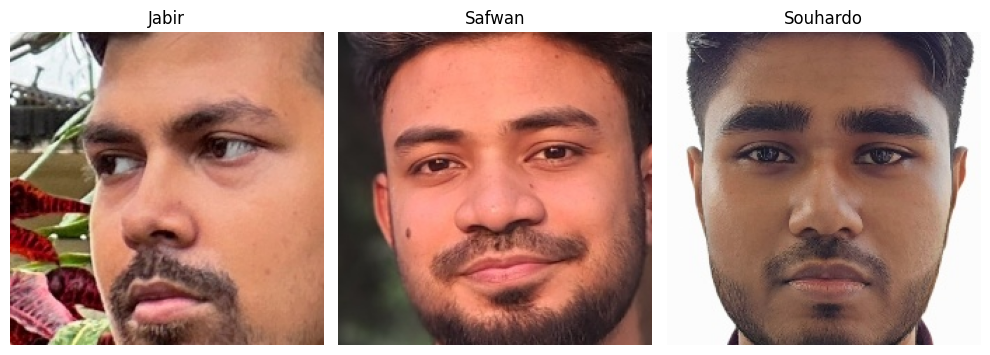

In [4]:
def plot_sample_images(data_dir, classes):
    plt.figure(figsize=(10, 5))
    for i, cls in enumerate(classes):
        img_path = next((data_dir / cls).glob("*"))
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(1, len(classes), i + 1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_sample_images(DATASET_DIR, class_names)

In [5]:
# Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    brightness_range=[0.7, 1.3],
    # shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation and testing
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    BASE_SPLIT_DIR / 'train', target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='sparse'
)
val_generator = val_test_datagen.flow_from_directory(
    BASE_SPLIT_DIR / 'val', target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='sparse'
)
test_generator = val_test_datagen.flow_from_directory(
    BASE_SPLIT_DIR / 'test', target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='sparse', shuffle=False
)

Found 205 images belonging to 3 classes.
Found 44 images belonging to 3 classes.
Found 45 images belonging to 3 classes.


In [11]:
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

from tensorflow.keras.optimizers import AdamW
model.compile(optimizer=AdamW(learning_rate=0.0001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)

# Save
MODELS_DIR.mkdir(exist_ok=True)
model.save(MODELS_DIR / "face_classifier.keras")
with open(MODELS_DIR / "class_names.json", "w") as f:
    json.dump(class_names, f)

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 440ms/step - accuracy: 0.3659 - loss: 1.1618 - val_accuracy: 0.3409 - val_loss: 1.0880
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 408ms/step - accuracy: 0.4439 - loss: 1.0679 - val_accuracy: 0.5227 - val_loss: 1.0262
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 436ms/step - accuracy: 0.5073 - loss: 0.9916 - val_accuracy: 0.4091 - val_loss: 0.9328
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 492ms/step - accuracy: 0.6293 - loss: 0.8944 - val_accuracy: 0.6136 - val_loss: 0.7993
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 497ms/step - accuracy: 0.6488 - loss: 0.7724 - val_accuracy: 0.8409 - val_loss: 0.6035
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 436ms/step - accuracy: 0.8585 - loss: 0.5690 - val_accuracy: 0.7273 - val_loss: 0.6907
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 390ms/step - accuracy: 0.8000 - loss: 0.5413 - val_accuracy: 0.9318 - val_loss: 0.3844
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 412ms/step - accuracy: 0.8390 - loss: 0.4457 - val_accu

In [15]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,736,331 (254.58 MB)

 Trainable params: 22,245,443 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 44,490,888 (169.72 MB)

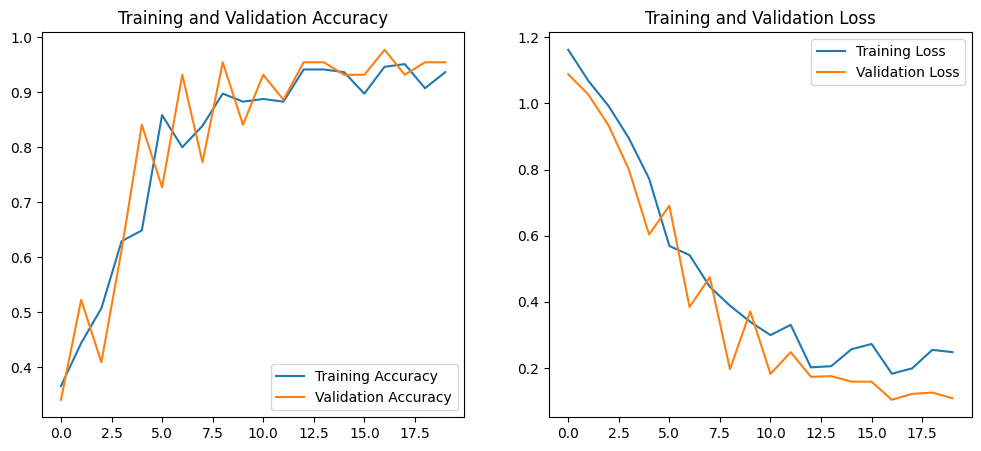

In [12]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.show()

plot_history(history)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


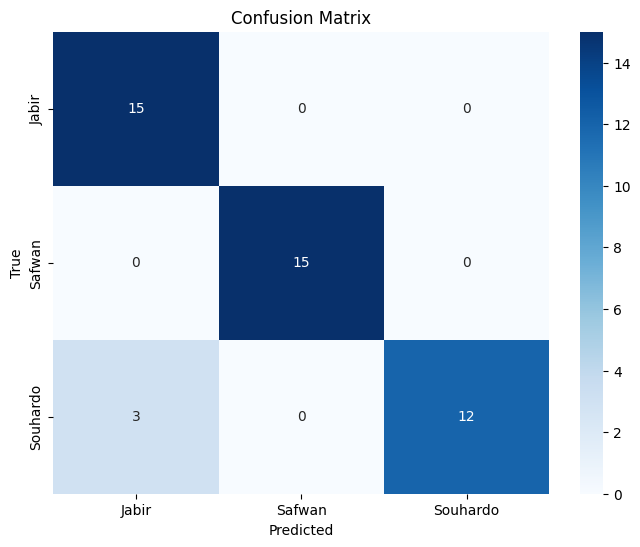


Classification Report:

              precision    recall  f1-score   support

       Jabir       0.83      1.00      0.91        15
      Safwan       1.00      1.00      1.00        15
    Souhardo       1.00      0.80      0.89        15

    accuracy                           0.93        45
   macro avg       0.94      0.93      0.93        45
weighted avg       0.94      0.93      0.93        45



In [13]:
def evaluate_model(model, test_gen, classes):
    # Get predictions
    y_pred_probs = model.predict(test_gen)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_gen.classes
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=classes))

evaluate_model(model, test_generator, class_names)

In [ ]:
def run_webcam_inference():
    # Load model and names
    model = models.load_model(MODELS_DIR / "face_classifier.keras")
    with open(MODELS_DIR / "class_names.json", "r") as f:
        labels = json.load(f)

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    cap = cv2.VideoCapture(0)

    while True:
        check, frame = cap.read()
        if not check: break

        frame = cv2.flip(frame, 1)
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)

        for (x, y, w, h) in faces:
            roi = cv2.resize(frame[y:y+h, x:x+w], IMG_SIZE)
            roi = roi.astype("float32") / 255.0
            roi = np.expand_dims(roi, axis=0)

            preds = model.predict(roi, verbose=0)[0]
            idx = np.argmax(preds)
            score = preds[idx]

            label = f"{labels[idx]} ({score:.2f})" if score > 0.75 else "UNKNOWN"
            color = (0, 255, 0) if "UNKNOWN" not in label else (0, 0, 255)
            
            cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
            cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

        cv2.imshow('Face Recognition Live', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'): break

    cap.release()
    cv2.destroyAllWindows()

run_webcam_inference()